# ASR中常用的语音特征之FBank和MFCC（原理 + Python实现）

一步一步讲解和实现ASR中常用的语音特征——FBank和MFCC的提取，包括算法原理、代码和可视化等。

完整Jupyter Notebook链接：https://github.com/Magic-Bubble/SpeechProcessForMachineLearning/blob/master/speech_process.ipynb

## 语音信号的产生

语音通常是指人说话的声音。从生物学的角度来看，是气流通过声带、咽喉、口腔、鼻腔等发出声音；从信号的角度来看，不同位置的震动频率不一样，最后的信号是由基频和一些谐波构成。

<img src='./resources/speech_production_model.png' width='55%'>


之后被设备接收后（比如麦克风），会通过A/D转换，将模拟信号转换为数字信号，一般会有采样、量化和编码三个步骤，采样率要遵循奈奎斯特采样定律：$fs >= 2f$，比如电话语音的频率一般在300Hz~3400Hz，所以采用8kHz的采样率足矣。

下面采用一个30s左右的16比特PCM编码后的语音wav为例。

## 准备工作

### 1. 导包

In [92]:
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
%matplotlib inline

### 2. 绘图工具

In [93]:
# 绘制时域图
def plot_time(signal, sample_rate):
    time = np.arange(0, len(signal)) * (1.0 / sample_rate)
    plt.figure(figsize=(20, 5))
    plt.plot(time, signal)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.grid()

# 绘制频域图
def plot_freq(signal, sample_rate, fft_size=512):
    xf = np.fft.rfft(signal, fft_size) / fft_size
    freqs = np.linspace(0, sample_rate/2, int(fft_size/2 + 1))
    xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
    plt.figure(figsize=(20, 5))
    plt.plot(freqs, xfp)
    plt.xlabel('Freq(hz)')
    plt.ylabel('dB')
    plt.grid()

# 绘制频谱图
def plot_spectrogram(spec, note):
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(note)
    plt.tight_layout()

### 3. 数据准备

In [96]:
# sample_rate, signal = wavfile.read('../data/OSR_us_000_0010_8k.wav') 
signal, sample_rate = sf.read('../data/test/0a6a36fb6.flac', dtype='int16')
# signal = signal[0: int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
print('sample rate:', sample_rate, ', frame length:', len(signal))

sample rate: 48000 , frame length: 2880000


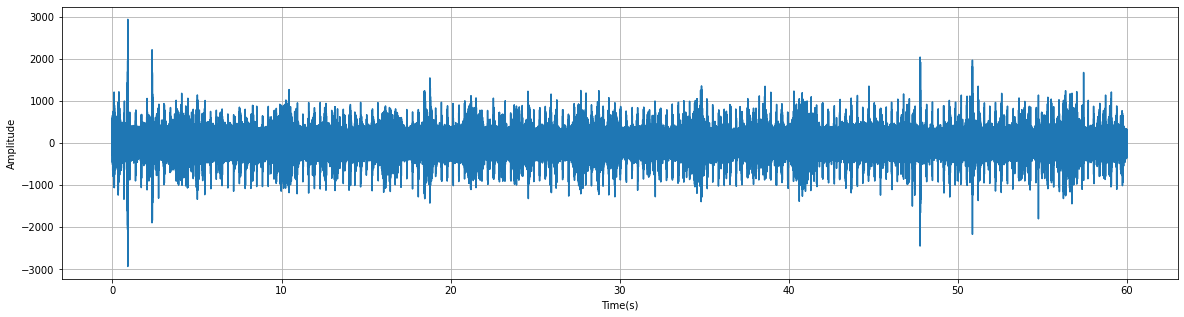

In [97]:
plot_time(signal, sample_rate)

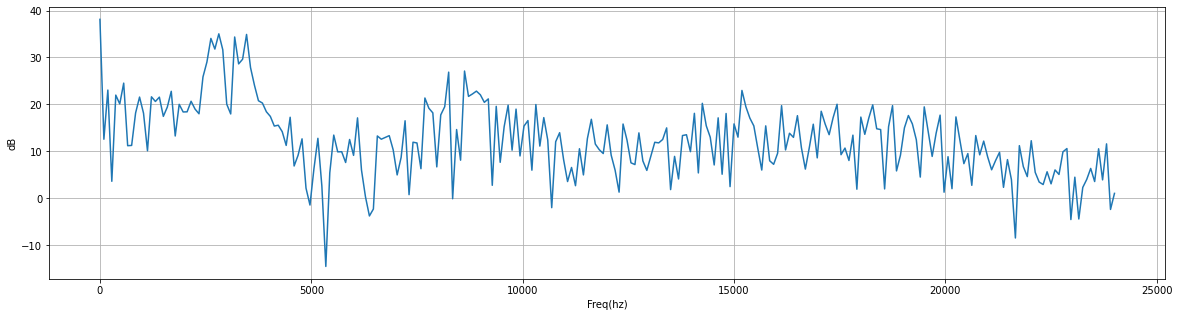

In [98]:
plot_freq(signal, sample_rate)

## 预加重（Pre-Emphasis）

预加重一般是数字语音信号处理的第一步。语音信号往往会有频谱倾斜（Spectral Tilt）现象，即高频部分的幅度会比低频部分的小，预加重在这里就是起到一个平衡频谱的作用，增大高频部分的幅度。它使用如下的一阶滤波器来实现：

$$y(t) = x(t) - \alpha x(t-1), \ \ \ \  0.95 < \alpha < 0.99$$

笔者对这个公式的理解是：信号频率的高低主要是由信号电平变化的速度所决定，对信号做一阶差分时，高频部分（变化快的地方）差分值大，低频部分（变化慢的地方）差分值小，达到平衡频谱的作用。

In [99]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

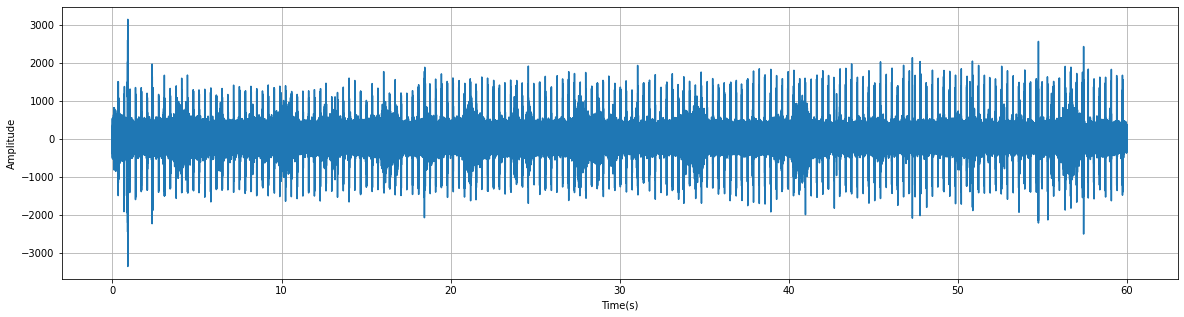

In [100]:
plot_time(emphasized_signal, sample_rate)

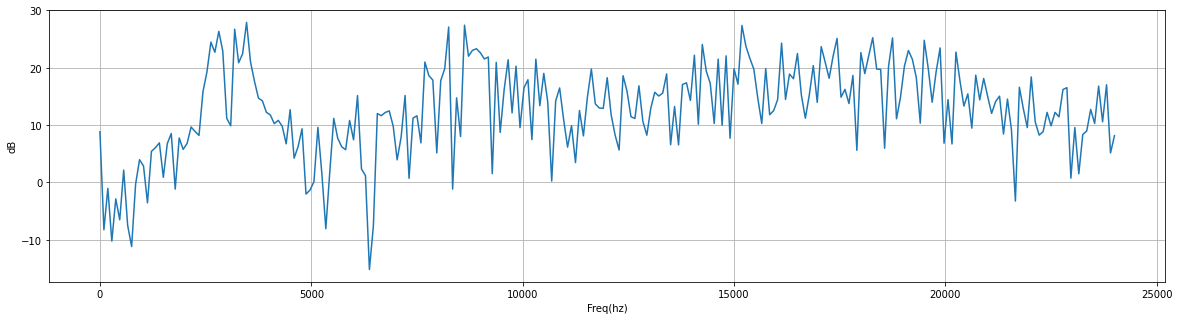

In [101]:
plot_freq(emphasized_signal, sample_rate)

从下面这个图来看，确实起到了平衡频谱的作用。

## 分帧（Framing）

在预加重之后，需要将信号分成短时帧。做这一步的原因是：信号中的频率会随时间变化（不稳定的），一些信号处理算法（比如傅里叶变换）通常希望信号是稳定，也就是说对整个信号进行处理是没有意义的，因为信号的频率轮廓会随着时间的推移而丢失。为了避免这种情况，需要对信号进行分帧处理，认为每一帧之内的信号是短时不变的。一般设置帧长取20ms~40ms，相邻帧之间50%（+/-10%）的覆盖。对于ASR而言，通常取帧长为25ms，覆盖为10ms。

In [102]:
frame_size, frame_stride = 0.025, 0.01
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
signal_length = len(emphasized_signal)
num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

pad_signal_length = (num_frames - 1) * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)

indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
frames = pad_signal[indices]

print(frames.shape)
print(f"frame_length: {frame_length}\tframe_step:{frame_step}")
print(f"signal_length: {signal_length}\tnum_frames:{num_frames}")

(5999, 1200)
frame_length: 1200	frame_step:480
signal_length: 2880000	num_frames:5999


## 加窗（Window）

在分帧之后，通常需要对每帧的信号进行加窗处理。目的是让帧两端平滑地衰减，这样可以降低后续傅里叶变换后旁瓣的强度，取得更高质量的频谱。常用的窗有：矩形窗、汉明（Hamming）窗、汉宁窗（Hanning），以汉明窗为例，其窗函数为：

$$w(n) = 0.54 - 0.46 cos(\frac{2\pi n}{N-1})$$

这里的$0<=n<=N-1$，$N$是窗的宽度。

In [103]:
hamming = np.hamming(frame_length)
# hamming = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(0, frame_length) / (frame_length - 1))

Text(0, 0.5, 'Amplitude')

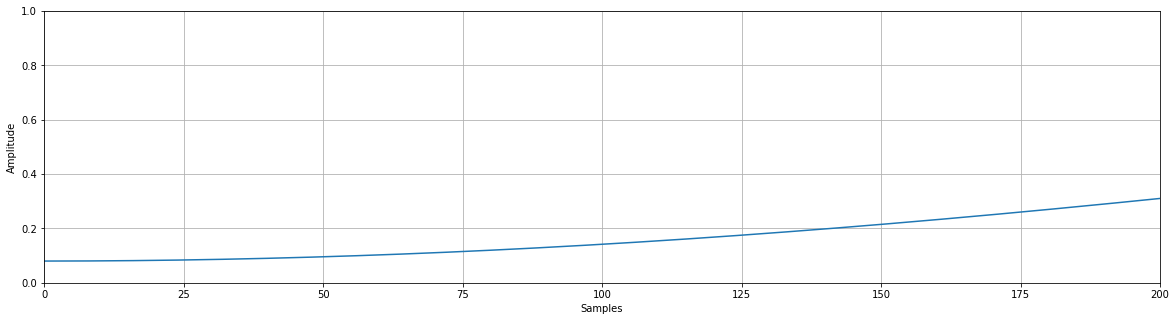

In [104]:
plt.figure(figsize=(20, 5))
plt.plot(hamming)
plt.grid()
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.xlabel('Samples')
plt.ylabel('Amplitude')

In [105]:
frames *= hamming
print(frames.shape)

(5999, 1200)


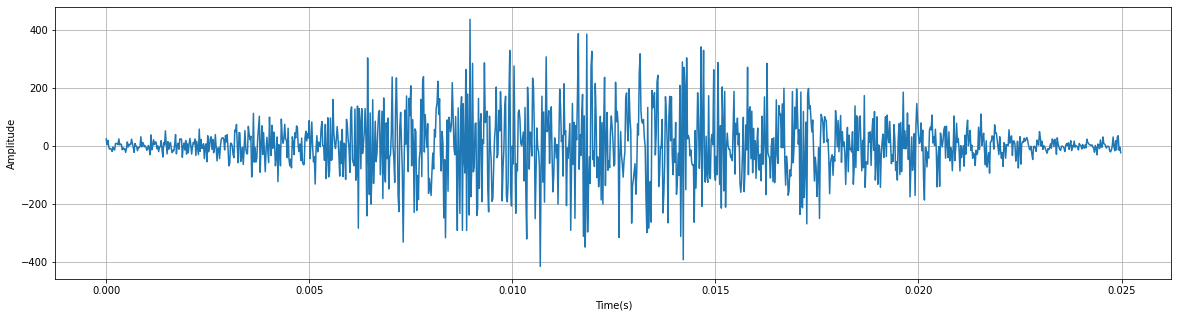

In [106]:
plot_time(frames[0], sample_rate)

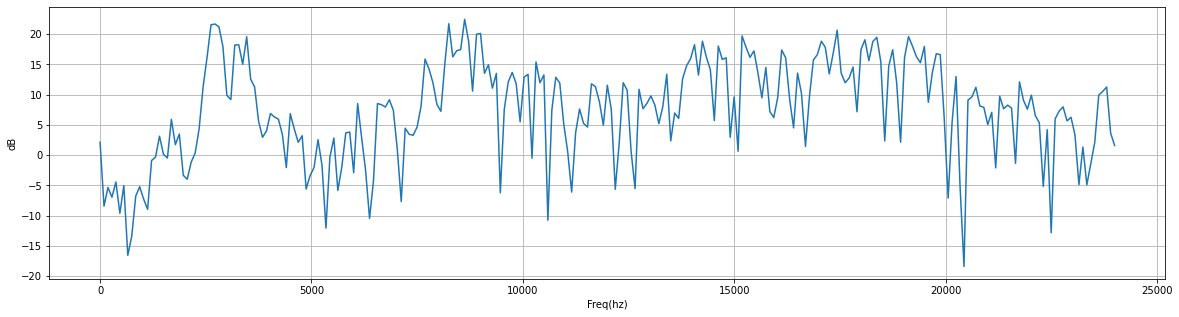

In [107]:
plot_freq(frames[0], sample_rate)

## 快速傅里叶变换（FFT）

对于每一帧的加窗信号，进行N点FFT变换，也称短时傅里叶变换（STFT），N通常取256或512，然后用如下的公式计算能量谱：

$$ P = \frac{|FFT(x_i)|^2}{N}$$

In [121]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
print(pow_frames.shape)

(5999, 257)


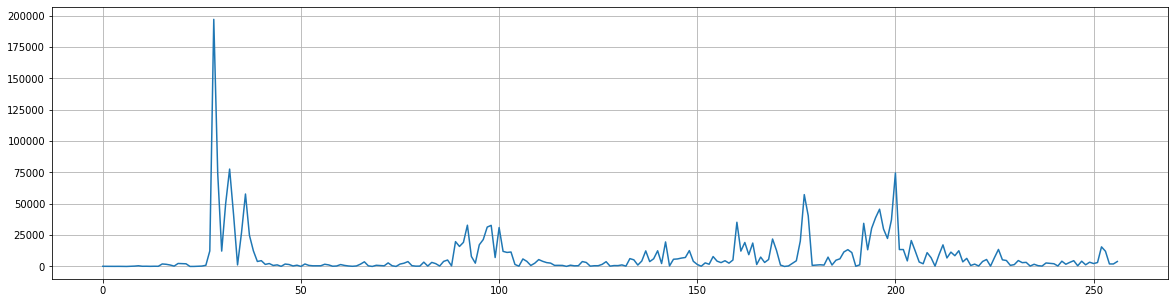

In [122]:
plt.figure(figsize=(20, 5))
plt.plot(pow_frames[1])
plt.grid()

## FBank特征（Filter Banks）

经过上面的步骤之后，在能量谱上应用Mel滤波器组，就能提取到FBank特征。

在介绍Mel滤波器组之前，先介绍一下Mel刻度，这是一个能模拟人耳接收声音规律的刻度，人耳在接收声音时呈现非线性状态，对高频的更不敏感，因此Mel刻度在低频区分辨度较高，在高频区分辨度较低，与频率之间的换算关系为：

$$m = 2595 log_{10} (1 + \frac{f}{700})$$

$$f = 700(10^{m/2595} - 1)$$

Mel滤波器组就是一系列的三角形滤波器，通常有40个或80个，在中心频率点响应值为1，在两边的滤波器中心点衰减到0，如下图：

<img src='./resources/mel_filters.jpg' width='80%'>

具体公式可以写为：

$$
H_m(k) =
  \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m + 1) \\
  \end{cases}
$$

最后在能量谱上应用Mel滤波器组，其公式为：

$$Y_t(m) = \sum_{k=1}^{N} H_m(k)|X_t(k)|^2 $$

其中，k表示FFT变换后的编号，m表示mel滤波器的编号。

In [110]:
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
print(low_freq_mel, high_freq_mel)

0 4016.019179871836


In [111]:
nfilt = 40
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 所有的mel中心点，为了方便后面计算mel滤波器组，左右两边各补一个中心点
hz_points = 700 * (10 ** (mel_points / 2595) - 1)

In [112]:
fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))  # 各个mel滤波器在能量谱对应点的取值
bin = (hz_points / (sample_rate / 2)) * (NFFT / 2)  # 各个mel滤波器中心点对应FFT的区域编码，找到有值的位置
for i in range(1, nfilt + 1):
    left = int(bin[i-1])
    center = int(bin[i])
    right = int(bin[i+1])
    for j in range(left, center):
        fbank[i-1, j+1] = (j + 1 - bin[i-1]) / (bin[i] - bin[i-1])
    for j in range(center, right):
        fbank[i-1, j+1] = (bin[i+1] - (j + 1)) / (bin[i+1] - bin[i])
print(fbank)
print(fbank.shape)

[[0.         0.56459975 0.         ... 0.         0.         0.        ]
 [0.         0.43540025 0.27800312 ... 0.         0.         0.        ]
 [0.         0.         0.72199688 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.0911907  0.04559535 0.        ]]
(40, 257)


In [123]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB
print(filter_banks.shape)

(5999, 40)


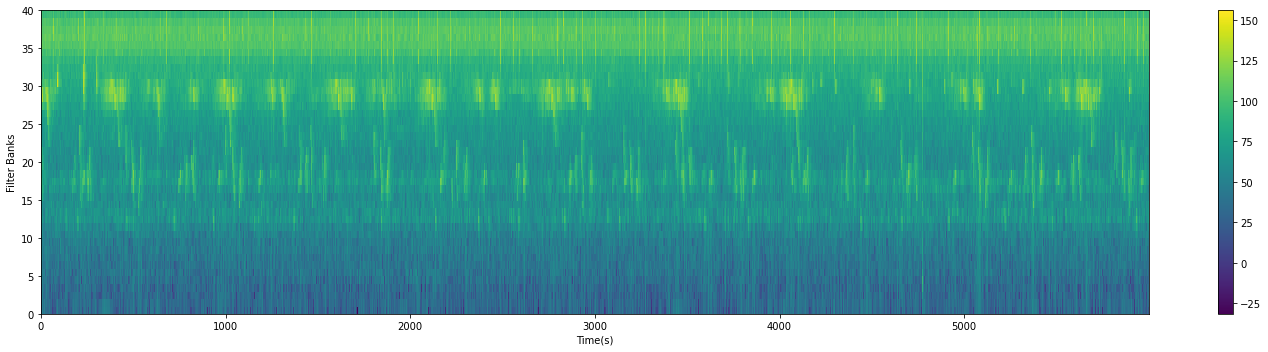

In [124]:
plot_spectrogram(filter_banks.T, 'Filter Banks')

PS：“log mel-filter bank outputs”和“FBANK features”说的是同一个东西。

## MFCC特征（Mel-frequency Cepstral Coefficients）

前面提取到的FBank特征，往往是高度相关的。因此可以继续用DCT变换，将这些相关的滤波器组系数进行压缩。对于ASR来说，通常取2~13维，扔掉的信息里面包含滤波器组系数快速变化部分，这些细节信息在ASR任务上可能没有帮助。

DCT变换其实是逆傅里叶变换的等价替代：

$$y_t(n) = \sum_{m=0}^{M-1}log(Y_t(m))cos(n(m + 0.5) \frac{\pi}{M}), \ \ \ \ \ n = 0, ..., J$$

所以MFCC名字里面有倒谱（Cepstral）。

In [115]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps+1)]
print(mfcc.shape)

(5999, 12)


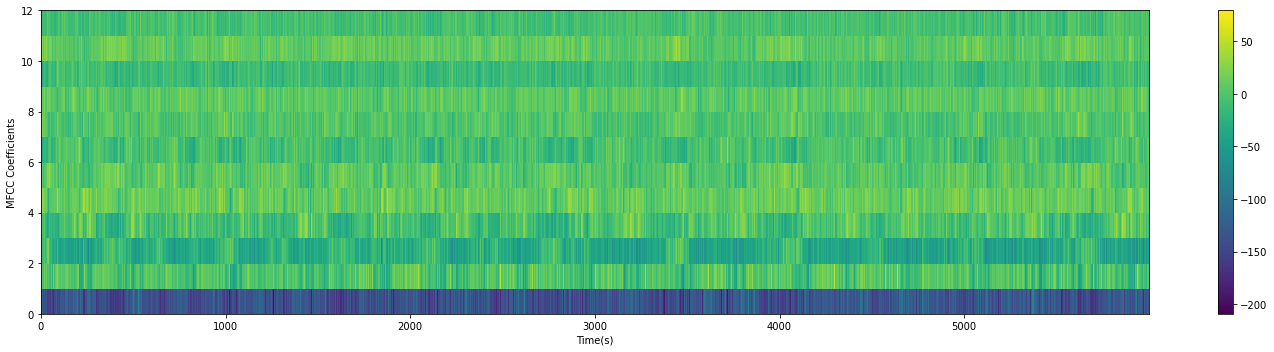

In [116]:
plot_spectrogram(mfcc.T, 'MFCC Coefficients')

一般对于ASR来说，对MFCC进行一个正弦提升（sinusoidal liftering）操作，可以提升在噪声信号中最后的识别率：

$$MFCC'_i = w_i MFCC_i$$

$$w_i = \frac{D}{2} sin(\frac{\pi * i}{D})$$

从公式看，猜测原因可能是对频谱做一个平滑，如果$D$取值较大时，会加重高频部分，使得噪声被弱化？

In [117]:
cep_lifter = 23
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

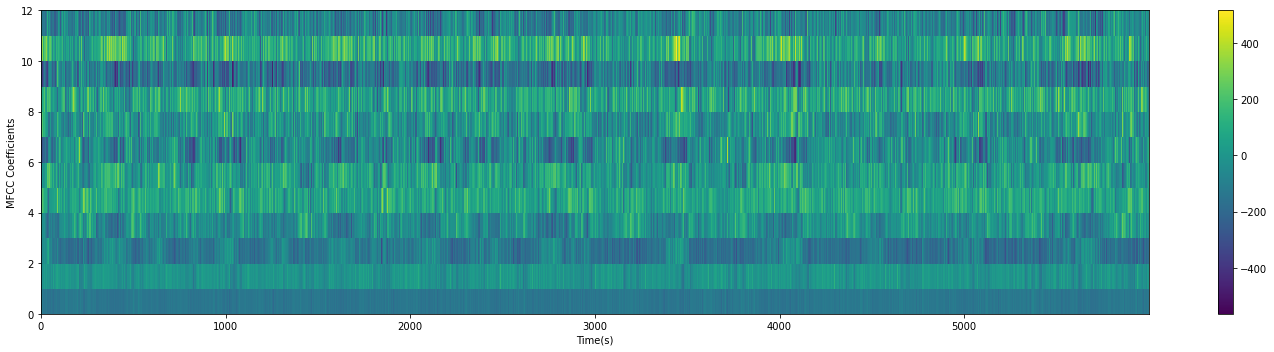

In [118]:
plot_spectrogram(mfcc.T, 'MFCC Coefficients')

## FBank与MFCC比较

FBank特征的提取更多的是希望符合声音信号的本质，拟合人耳接收的特性。而MFCC特征多的那一步则是受限于一些机器学习算法。很早之前MFCC特征和GMMs-HMMs方法结合是ASR的主流。而当一些深度学习方法出来之后，MFCC则不一定是最优选择，因为神经网络对高度相关的信息不敏感，而且DCT变换是线性的，会丢失语音信号中原本的一些非线性成分。

还有一些说法是在质疑傅里叶变换的使用，因为傅里叶变换也是线性的。因此也有很多方法，设计模型直接从原始的音频信号中提取特征，但这种方法会增加模型的复杂度，而且本身傅里叶变换不太容易拟合。同时傅里叶变换是在短时上应用的，可以建设信号在这个短的时间内是静止的，因此傅里叶变换的线性也不会造成很严重的问题。

结论就是：在模型对高相关的信号不敏感时（比如神经网络），可以用FBank特征；在模型对高相关的信号敏感时（比如GMMs-HMMs），需要用MFCC特征。从目前的趋势来看，因为神经网络的逐步发展，FBank特征越来越流行。

## 其他特征

1. PLP（Perceptual Linear Prediction）

另外一种特征，与MFCC相比有一些优势，具体提取方式见下图：

<img src='./resources/plp.png' width='60%'>

2. 动态特征

加入表现帧之间变化的特征，用如下公式：

$$d(t) = \frac{c(t+1) - c(t-1)}{2}$$

一般在ASR中使用的特征（用于GMM相关的系统），是39维的；包括(12维MFCC+1维能量) + delta + delta^2

具体提取过程见下图：

<img src='./resources/39d_feature.png' width='60%'>

## 标准化

其目的是希望减少训练集与测试集之间的不匹配。有三种操作：

1. 去均值 （CMN）

为了均衡频谱，提升信噪比，可以做一个去均值的操作

In [119]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

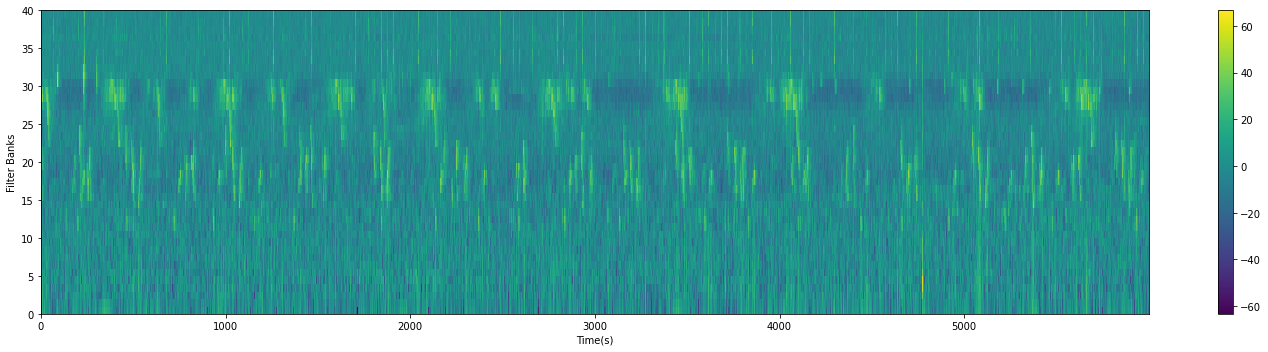

In [120]:
plot_spectrogram(filter_banks.T, 'Filter Banks')

In [125]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

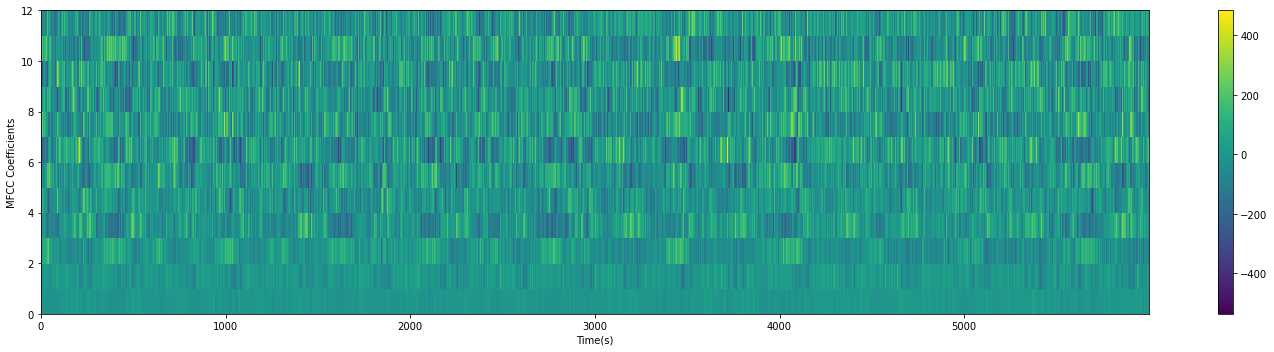

In [126]:
plot_spectrogram(mfcc.T, 'MFCC Coefficients')

2. 方差归一（CVN）

除以标准差，从而使得方差为1

3. 标准化（CMVN）

$$y_t(j) = \frac{y_t(j) - \mu (y(j))}{\sigma (y(j))}$$

PS：这些操作，还可以针对speaker/channel做；在实时情景下，可以计算moving average。

## 传送门

[Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html) 一个很优质，讲的很清楚的英文博客

[Speech Signal Analysis](http://www.inf.ed.ac.uk/teaching/courses/asr/2018-19/asr02-signal-handout.pdf) 英国爱丁堡大学一门ASR课程的讲义

[python_speech_features](https://github.com/jameslyons/python_speech_features) 一个很成熟的python提取这些特征的包

[ASR中常用的语音特征之FBank和MFCC（原理 + Python实现）](https://blog.csdn.net/Magical_Bubble/article/details/90295814) 个人博客